In [18]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'real-life-industrial-dataset-of-casting-product:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F487456%2F1300891%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240924%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240924T170722Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1a5b023e76c9960603ae5aaea95f064ee3fe62ec954b9a393eb428ca7a23014433990957dc8973642a0b036b3fac2a236f93c1b60f0a4c065bad29f9d6524e777d5ab2385c07d74cea1b55c867482eac60b360b3bc1c1d2dcda53b31264c44a063b19f6cf2fdaca6082670f5f86fa89814d6fa6053410bb3d767346807d68e1d13494ea97a5b3c3c6db22c49137539c3f2346eb697959338d82cc801eaa5486277224115b7628068ca9d3f2b7313e969577faeec0bdef7b2b205fb71bbb7068322b2653dfcf3dbfd851178f2f53ac1b193a213e3ce18d5a109af7997395c7bea1f5203d7b88336950feacc38404fe44036855db301b5afaa3a6da8e6281f735b,our-uploaded-dataset-name:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5760675%2F9472494%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240924%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240924T170722Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8e99da2d2046c23234c6b8c54c35e11e21e5039ecadc8b2c9297b85df29e37bf5c4bd1f9f4fab4f95ce2d8a7b0c2e30eea713732b08b366fae9ebb9648a831672a63a0dc5b6dd61b0b91ba57998fc644f1bfe85c64beecb3df67d6eb075d6a518fec68b535f06e7304926c3794f83afc2ab083f699aebf44e85566220f92a3f29dc8173aaab0fe054b47919b42b53e18c69a7b6ca17cb449fc2a23e37ba52e627d963b70e6a3c2f43fe9cbe10d537ede58eadd3cd43275f0a8f1cc9dcf5caa5f4ed9486ca656d7d33c90e670134fc245d5ddd875f8afb388740307b5694dd47de02cebe8a6a60cd36bc7e8f5e760df53e7d378ba1b55195a31953775568d2777,your-uploaded-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5760739%2F9472587%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240924%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240924T170722Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D35ec6cfa3b78f144edba81909349aa867ce887499819096f4d28641c6d2bc76e5bf8819392cf262c29e8dd687013eba92e2bd79709ad98fe15cc4946b0dcaf94fab332649c26d3e44bc89f92b4ac69f10da7454dc605ba51ddcd72dd32847485ec37b01f2ef227a5b427bd64d1797957d25f5c991dc5bb94a0b60a80518d3c31341520fe5a0e8604d8c7e5df2613e6549e45724b587e6d2ed41cf5ebf38a03e3e85ab33196acbfdb323d2986bce0963f9294215fffdb7cdde6e45518e28e30dda52629ae7248d6524c370d0a8920bfa0626e8d10ffe7339d1dc8245b8a4420451e319811f3abc37b1cea5c2e7909e69e5ee0bd51ac590471578ed584d4323a95'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 104965698 bytes downloaded
Downloaded and uncompressed: real-life-industrial-dataset-of-casting-product
[==================================================] 87541466 bytes downloaded
Downloaded and uncompressed: our-uploaded-dataset-name
[==================================================] 217513846 bytes downloaded
Downloaded and uncompressed: your-uploaded-dataset
Data source import complete.


In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/def_front/cast_def_0_9495.jpeg
/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/def_front/cast_def_0_4588.jpeg
/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/def_front/cast_def_0_7241.jpeg
/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/def_front/cast_def_0_4323.jpeg
/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/def_front/cast_def_0_6431.jpeg
/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/def_front/cast_def_0_7219.jpeg
/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/def_front/cast_def_0_9765.jpeg
/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data

In [20]:
import os
import cv2
import time
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC,Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from tensorflow.keras.applications import Xception,VGG19,ResNet50,InceptionResNetV2,ResNet152V2,EfficientNetB2,ConvNeXtTiny
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,GlobalMaxPooling2D,Dropout
random.seed(555)

# **Read and Preparation of Data**

In [21]:
dir_train = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train'
dir_test = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/test'

In [22]:
# Train
dir_train_def = dir_train + '/def_front/'
dir_train_ok = dir_train + '/ok_front/'
# Test
dir_test_def = dir_test + '/def_front/'
dir_test_ok = dir_test + '/ok_front/'


In [23]:
image_files_train_def = os.listdir(dir_train_def)
image_files_train_ok = os.listdir(dir_train_ok)

In [24]:
n = len(image_files_train_def)
m = len(image_files_train_ok)
print(f'the number of all the images in the training set is {n+m}')
print(f'number of def imgs is {n}')
print(f'number of ok imgs is {m}')
print(f'the ratio between ok and def imgs is {m/n}')

the number of all the images in the training set is 6633
number of def imgs is 3758
number of ok imgs is 2875
the ratio between ok and def imgs is 0.7650345928685471


# **Example of def and ok folders**

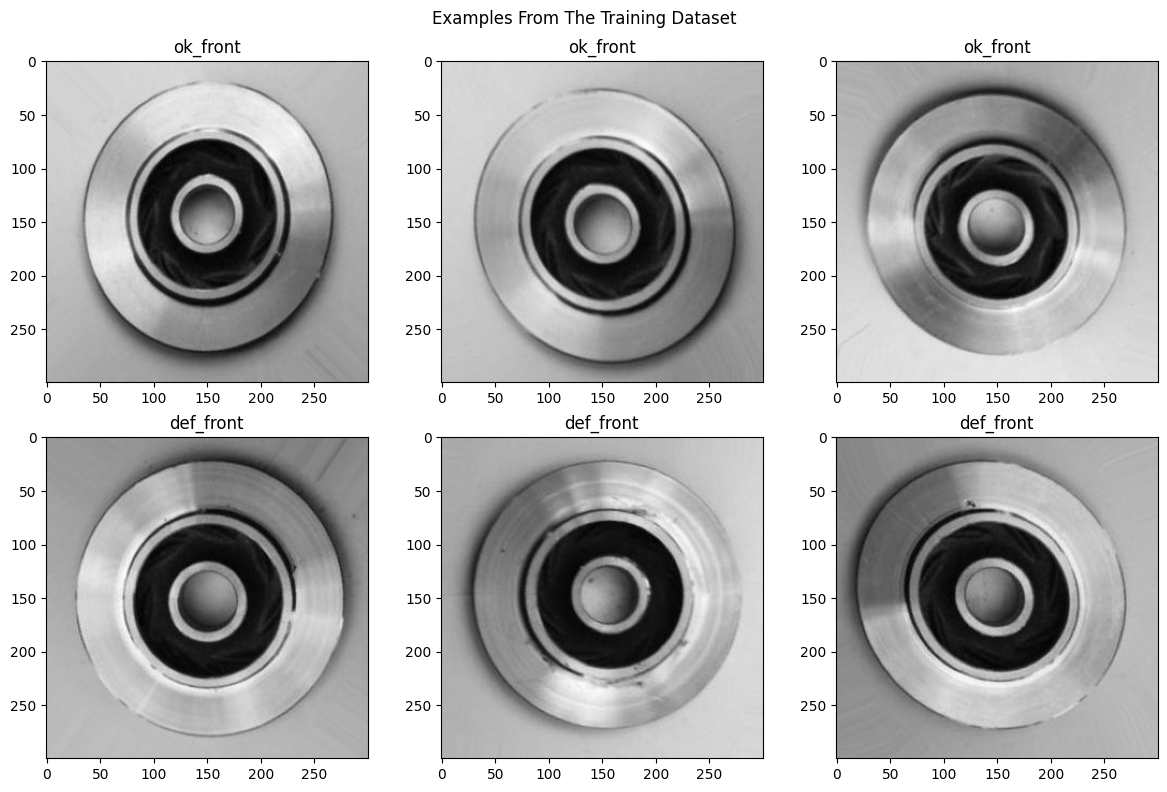

In [25]:
# Function to get a list of random image files from a directory
def get_random_image_files(directory, num_files):
    files = os.listdir(directory)
    random.shuffle(files)
    return files[:num_files]

# Create a 2x3 grid for "ok_front" images
plt.figure(figsize=(12, 8))
plt.suptitle('Examples From The Training Dataset')

for i in range(3):
    plt.subplot(2, 3, i + 1)
    image_files_ok = get_random_image_files(dir_train_ok, 3)
    img = Image.open(os.path.join(dir_train_ok, image_files_ok[i]))
    plt.imshow(img)
    plt.title('ok_front')

# Create a 2x3 grid for "def_front" images
for i in range(3):
    plt.subplot(2, 3, i + 4)
    image_files_def = get_random_image_files(dir_train_def, 3)
    img = Image.open(os.path.join(dir_train_def, image_files_def[i]))
    plt.imshow(img)
    plt.title('def_front')

plt.tight_layout()
plt.show()

# **Image Details Extraction**

In [26]:
# same for the ok_front
img = Image.open(os.path.join(dir_train_def, image_files_def[0]))
img.size, img.mode

((300, 300), 'RGB')

# **Data Augmentation**

In [27]:
img_size = (300,300)
rand_seed = 555
batch_size = 32
epochs = 5

In [28]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    brightness_range=[0.2, 1.5],
    validation_split=0.4,
)

test_gen = ImageDataGenerator(rescale=1./255)

# **Spliting data into training and validation set**

In [29]:
arg_train = {'target_size': img_size,
             'color_mode': 'rgb',
             'classes': {'ok_front': 0,
                         'def_front': 1},
             'class_mode': 'binary',
             'batch_size': batch_size,
             'seed': rand_seed}

arg_test = {'target_size': img_size,
            'color_mode': 'rgb',
            'classes': {'ok_front': 0,
                        'def_front': 1},
            'class_mode': 'binary',
            'batch_size': batch_size,
            'seed': rand_seed,
            'shuffle': False}

# 80%
train_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='training',
                                          **arg_train)
#20%
valid_set = train_gen.flow_from_directory(directory=dir_train,
                                          subset='validation',
                                          **arg_train)

# for the 0 and 1 ...etc
test_set = test_gen.flow_from_directory(directory=dir_test,
                                        **arg_test)

Found 3980 images belonging to 2 classes.
Found 2653 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


# **Training the Model**

In [30]:
weights_path = '/kaggle/input/your-uploaded-dataset/resnet152v2_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [31]:
from keras import regularizers

def load_pretrained_model(model_name):
    if model_name == 'Xception':
        return Xception(weights='imagenet', include_top=False)
    elif model_name == 'ResNet50':
        return ResNet50(weights='imagenet', include_top=False)
    elif model_name == 'InceptionResNetV2':
        return InceptionResNetV2(weights='imagenet', include_top=False)
    elif model_name == 'ResNet152V2':
        return ResNet152V2(weights=weights_path, include_top=False)



def create_and_compile_model(base_model, learning_rate=0.01):
    x = base_model.output
    x = GlobalMaxPooling2D()(x)

    # Correct usage of regularizer
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2())(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2())(x)

    predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model with the optimizer and the loss/metrics
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',  # Binary classification
                  metrics=['accuracy', AUC(), Precision(), Recall()])

    return model


In [32]:
def train_and_evaluate_model(model, model_name, train_set, valid_set, test_set, epochs=10, batch_size=32):
    model_checkpoint = ModelCheckpoint(
        filepath='best_model.keras',  # Updated file extension to `.keras`
        monitor='val_auc',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    )

    # Start the timer
    start_time = time.time()

    history = model.fit(
        train_set,
        steps_per_epoch=train_set.samples // batch_size,
        epochs=epochs,
        validation_data=valid_set,
        validation_steps=valid_set.samples // batch_size,
        callbacks=[model_checkpoint]
    )

    # End the timer
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model on the test set
    test_loss, *test_metrics = model.evaluate(test_set, steps=test_set.samples // batch_size)
    test_acc = test_metrics[0]
    test_auc = test_metrics[1]
    test_precision = test_metrics[2]
    test_recall = test_metrics[3]

    # Start the evaluation timer
    evaluation_time = time.time() - end_time

    # Print the results
    print(f"model: {model_name}")
    print(f"Test accuracy: {test_acc * 100:.2f}%")
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Evaluation time: {evaluation_time:.2f} seconds")

    y_true = test_set.classes
    y_pred = model.predict(test_set)
    y_pred_classes = (y_pred > 0.5).astype(int)  # Convert to 0 or 1 based on a threshold
    cm = confusion_matrix(y_true, y_pred_classes)
    report = classification_report(y_true, y_pred_classes)
    auc = roc_auc_score(y_true, y_pred)

    return test_acc, cm, report, auc, test_precision, test_recall, history.history


# **Running Epochs**

In [33]:
%%time

#model_names = ['Xception', 'InceptionResNetV2', 'ResNet152V2']
model_names = ['ResNet152V2']
results = {}

for model_name in model_names:
    print(f"Training model: {model_name}")
    base_model = load_pretrained_model(model_name)
    model = create_and_compile_model(base_model)
    test_acc, cm, report, auc, precision, recall, history = train_and_evaluate_model(model,
                                                         model_name,
                                                         train_set,
                                                         valid_set,
                                                         test_set,
                                                         epochs,
                                                         batch_size)

    results[model_name] = {
        'test_accuracy': test_acc,
        'confusion_matrix': cm,
        'classification_report': report,
        'roc_auc': auc,
        'history': history
    }

Training model: ResNet152V2
Epoch 1/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.7328 - auc_1: 0.7512 - loss: 13.5059 - precision_1: 0.7568 - recall_1: 0.7591 - val_accuracy: 0.9726 - val_auc_1: 0.9973 - val_loss: 0.0732 - val_precision_1: 0.9627 - val_recall_1: 0.9899
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_auc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9062 - auc_1: 1.0000 - loss: 0.1722 - precision_1: 0.8500 - recall_1: 1.0000 - val_accuracy: 0.9655 - val_auc_1: 0.9952 - val_loss: 0.1261 - val_precision_1: 1.0000 - val_recall_1: 0.9375
Epoch 3/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9764 - auc_1: 0.9961 - loss: 0.0699 - precision_1: 0.9832 - recall_1: 0.9743 - val_accuracy: 0.9901 - val_auc_1: 0.9960 - val_loss: 0.0548 - val_precision_1: 1.0000 - val_recall_1: 0.9825
Epoch 4/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - auc_1: 1.0000 - loss: 0.0017 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 1.0000 - val_auc_1: 1.0000 - val_loss: 0.0015 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 5/5
124/124 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9888 - auc_1: 0.9972 - loss: 0.0404 - precision_1: 0.9903 - recall_1: 0.9897 - val_accuracy: 0.9783 - val_auc_1: 0.9964 - val_loss: 0.0763 - val_precision_1: 1.0000 - val_recall_1: 0.

# **Inferencing the Model on validation ser**

Best Model: ResNet152V2
Test Accuracy: 97.16%
Confusion Matrix:
[[262   0]
 [ 21 432]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       262
           1       1.00      0.95      0.98       453

    accuracy                           0.97       715
   macro avg       0.96      0.98      0.97       715
weighted avg       0.97      0.97      0.97       715

ROC AUC: 1.00


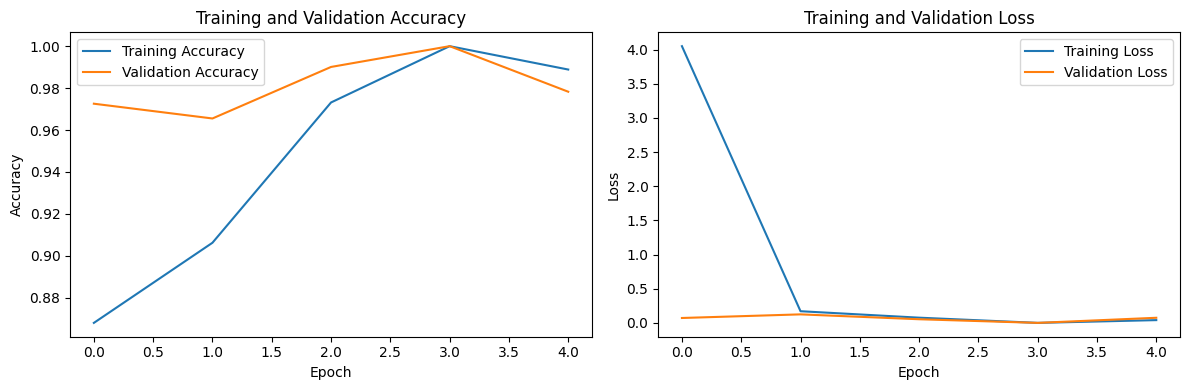

In [34]:
best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model_results = results[best_model_name]

# Access the performance metrics
best_test_acc = best_model_results['test_accuracy']
best_cm = best_model_results['confusion_matrix']
best_report = best_model_results['classification_report']
best_auc = best_model_results['roc_auc']
best_history = best_model_results['history']

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {best_test_acc * 100:.2f}%")
print("Confusion Matrix:")
print(best_cm)
print("Classification Report:")
print(best_report)
print(f"ROC AUC: {best_auc:.2f}")


# Plot training and validation accuracy and loss

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(best_history['accuracy'], label='Training Accuracy')
plt.plot(best_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_history['loss'], label='Training Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Validation Accuracy**

In [37]:
best_model = load_model("/content/best_model.keras")
# Assuming you have set up the 'test_set' as mentioned earlier
predictions = best_model.predict(test_set)
predicted_labels = (predictions > 0.5).astype(int)
true_labels = test_set.classes

# Calculate classification report and confusion matrix
print(classification_report(true_labels, predicted_labels))
conf_matrix = confusion_matrix(true_labels, predicted_labels)

23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 688ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       262
           1       0.99      0.99      0.99       453

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



# **Confusion Matrix**

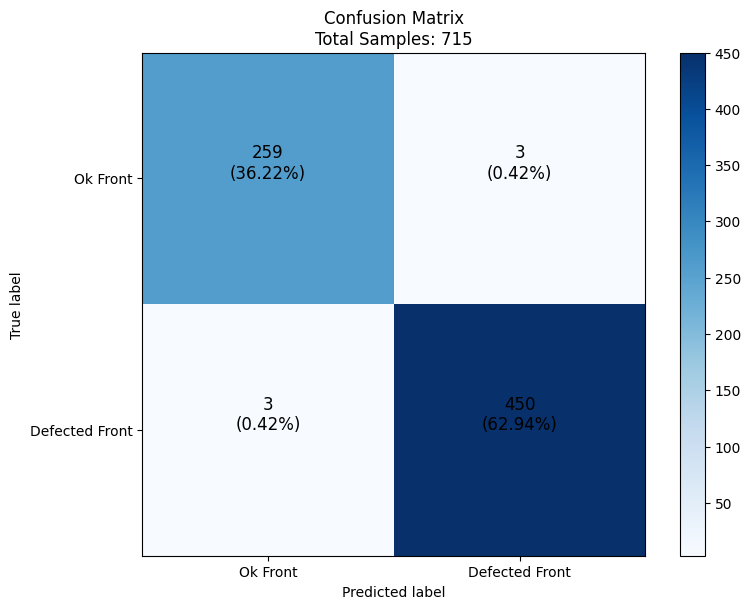

In [38]:
# Assuming you have 'conf_matrix' calculated as the confusion matrix
total_samples = np.sum(conf_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title(f'Confusion Matrix\nTotal Samples: {total_samples}')
plt.colorbar()
tick_marks = np.arange(2)  # Assuming you have 2 classes (0 and 1)
plt.xticks(tick_marks, ['Ok Front', 'Defected Front'])
plt.yticks(tick_marks, ['Ok Front', 'Defected Front'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add numbers inside the boxes with black color and percentages
for i in range(2):
    for j in range(2):
        count = conf_matrix[i, j]
        percentage = (count / total_samples) * 100
        plt.text(j, i, f'{count}\n({percentage:.2f}%)', horizontalalignment='center', color='black', fontsize=12)

plt.show()